In [1]:
#Load the libraries

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
#load the data
data_dir ='./EuroSAT_RGB'

In [3]:
#Transform the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

#here just using the mean and std as 0.5 as a proxy

dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

trainsize = int(0.8 * len(dataset))
testsize = len(dataset) - trainsize

traindataset, testdataset = torch.utils.data.random_split(dataset, [trainsize, testsize])

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testdataset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 
           'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake')

In [4]:
#Checking the dataset
dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ./EuroSAT_RGB
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

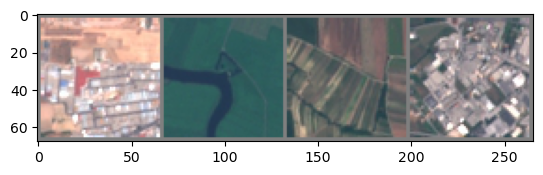

Labels: Industrial River PermanentCrop Industrial


In [5]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
dataiter = iter(trainloader)
#images, labels = dataiter.next()
images, labels = next(iter(trainloader))

imshow(torchvision.utils.make_grid(images[:4]))
print('Labels:',' '.join('%s' % classes[labels[j]] for j in range(4)))


### Here we are defining our CNN, we are starting with 3 in channels due to RGB format. For our scenario we are starting with a kernel_size of 5 and a stride of 2 for the first conv layer and then move the 3 and 2 to capture finer features

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(64, 128, 3, 2)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(25088, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=25088, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [7]:
# Set the device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())


### Network Training:

C:\Users\dlr93\anaconda3\Lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


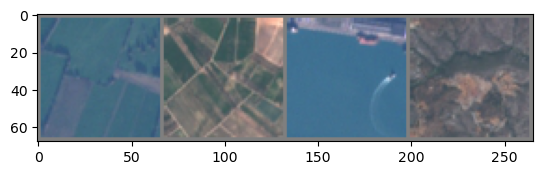

Predicted: Residential Residential River River


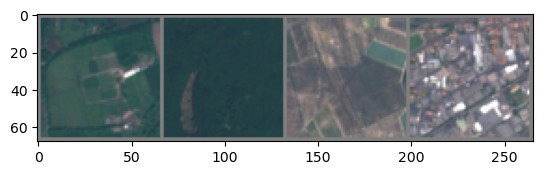

Predicted: Pasture SeaLake Residential Industrial


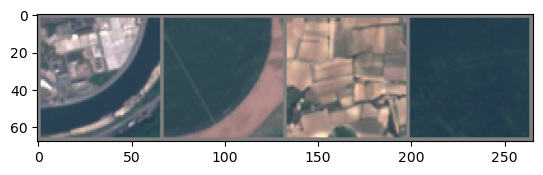

Predicted: Industrial River AnnualCrop Forest


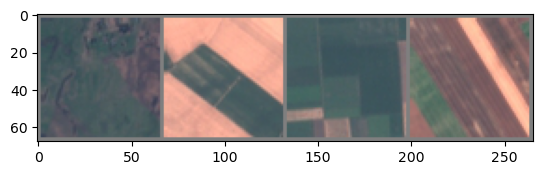

Predicted: HerbaceousVegetation AnnualCrop Forest AnnualCrop


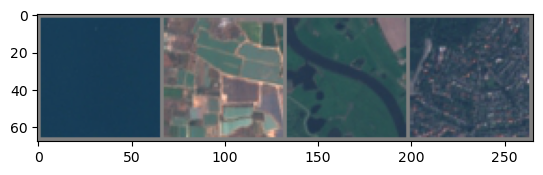

Predicted: SeaLake AnnualCrop SeaLake River


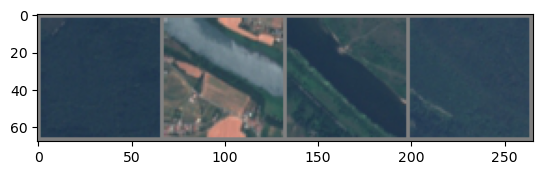

Predicted: Forest AnnualCrop River River


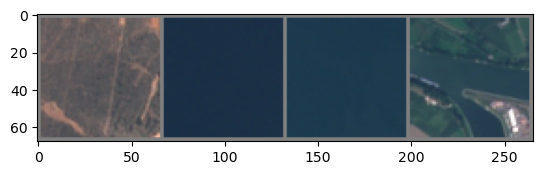

Predicted: HerbaceousVegetation Forest SeaLake River
Epoch 1, Loss: 1.347624073367147


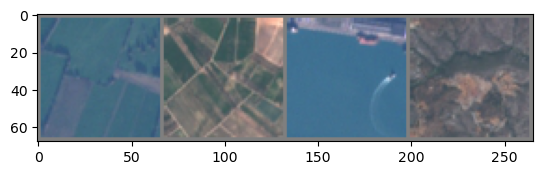

Predicted: Pasture PermanentCrop Pasture PermanentCrop


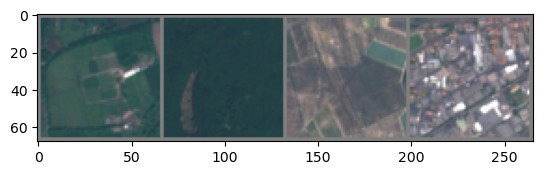

Predicted: Highway Forest HerbaceousVegetation Industrial


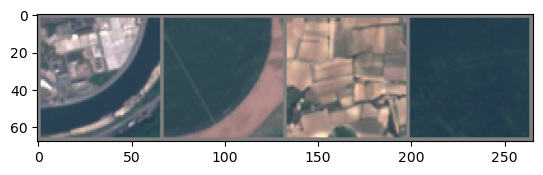

Predicted: Industrial AnnualCrop PermanentCrop Forest


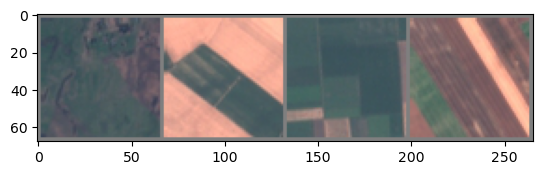

Predicted: Pasture AnnualCrop Pasture AnnualCrop


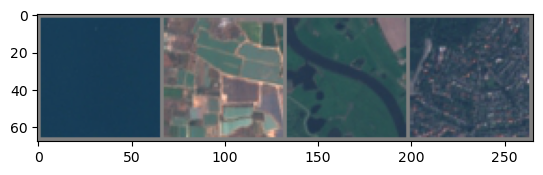

Predicted: SeaLake PermanentCrop Pasture River


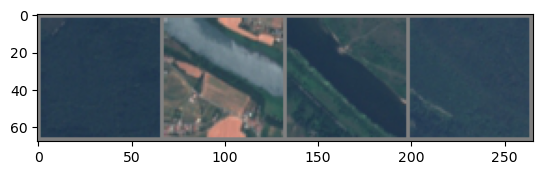

Predicted: Forest Highway River SeaLake


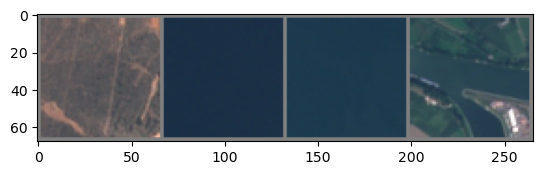

Predicted: PermanentCrop SeaLake SeaLake River
Epoch 2, Loss: 0.9777107455674008


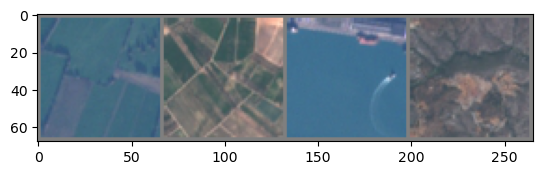

Predicted: Pasture PermanentCrop Pasture HerbaceousVegetation


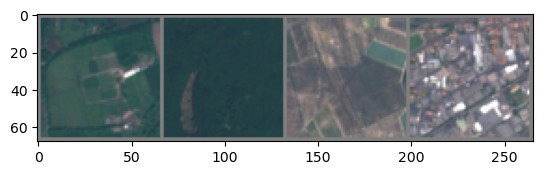

Predicted: Highway Forest PermanentCrop Industrial


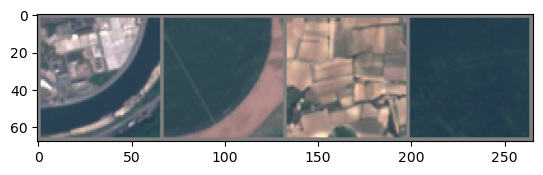

Predicted: Industrial AnnualCrop PermanentCrop Forest


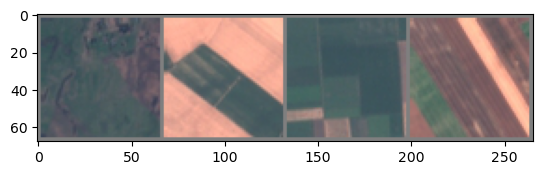

Predicted: HerbaceousVegetation AnnualCrop Pasture AnnualCrop


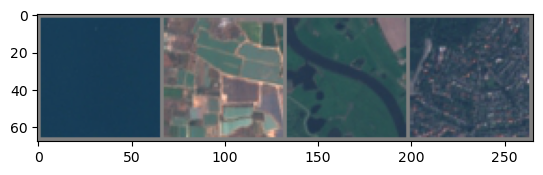

Predicted: SeaLake PermanentCrop AnnualCrop Residential


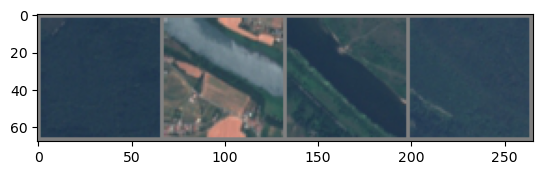

Predicted: Forest Highway River SeaLake


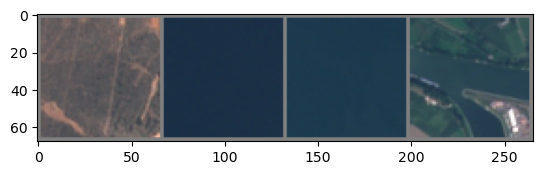

Predicted: HerbaceousVegetation Forest SeaLake River
Epoch 3, Loss: 0.8443664361739299


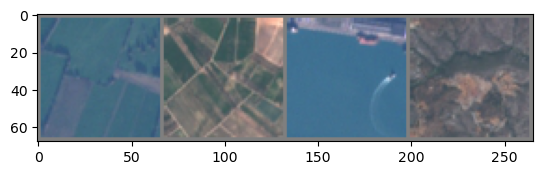

Predicted: Pasture PermanentCrop Pasture PermanentCrop


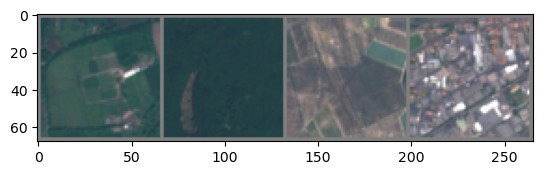

Predicted: Highway Forest HerbaceousVegetation Industrial


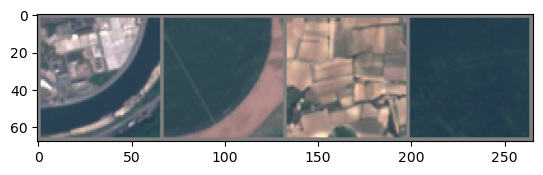

Predicted: Highway AnnualCrop PermanentCrop Forest


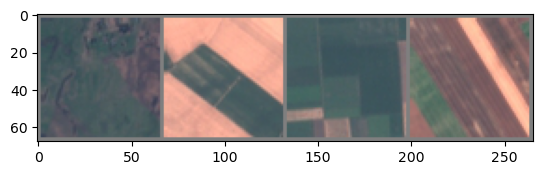

Predicted: HerbaceousVegetation AnnualCrop SeaLake AnnualCrop


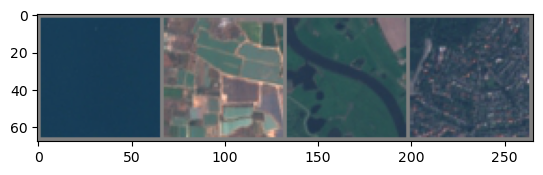

Predicted: SeaLake PermanentCrop River Residential


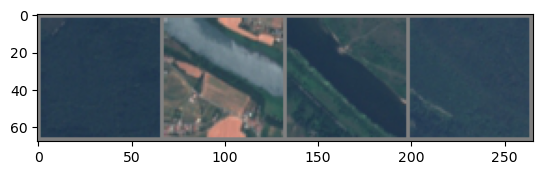

Predicted: Forest Highway River Forest


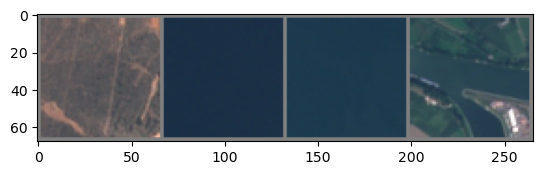

Predicted: HerbaceousVegetation Forest SeaLake River
Epoch 4, Loss: 0.7792533445640428


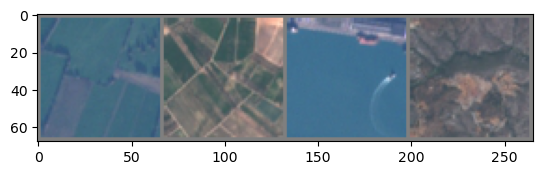

Predicted: Pasture Highway Pasture HerbaceousVegetation


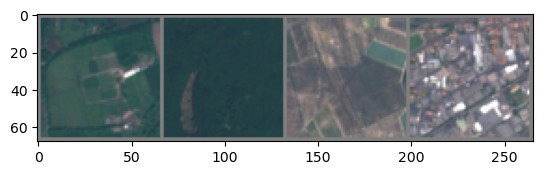

Predicted: Highway Forest HerbaceousVegetation Industrial


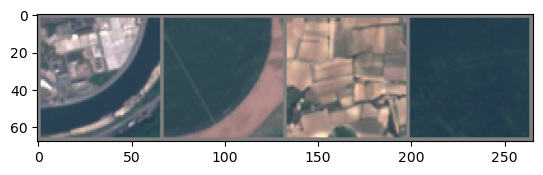

Predicted: Industrial AnnualCrop PermanentCrop Forest


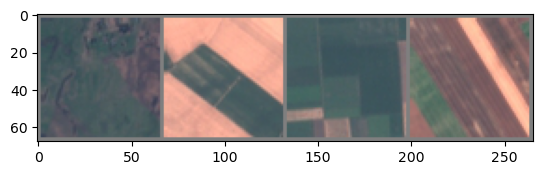

Predicted: Pasture AnnualCrop AnnualCrop PermanentCrop


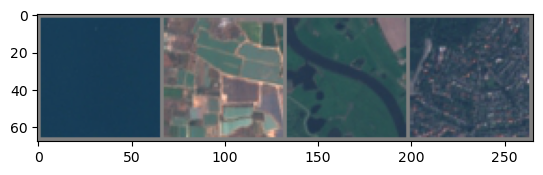

Predicted: Forest AnnualCrop River Highway


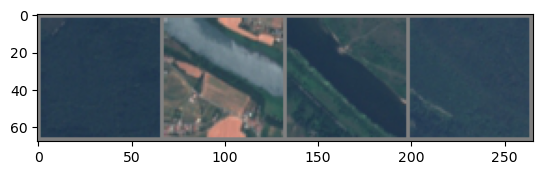

Predicted: Forest Highway River Forest


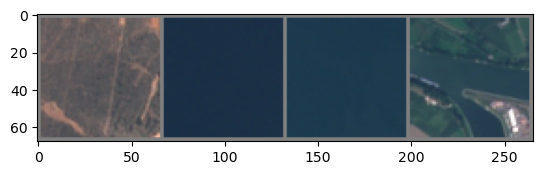

Predicted: HerbaceousVegetation SeaLake SeaLake River
Epoch 5, Loss: 0.6899405348406741
Finished Training


In [8]:
# Number of training epochs.
num_epochs = 5

# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0

    # Reset the test iterator at the beginning of each epoch
    testiter = iter(testloader)

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 0: #chenged this to not have many printings and run the network a bit faster
            with torch.no_grad():
                try:
                    test_images, test_labels = next(testiter)
                except StopIteration:
                    # we included this exception handling because it was getting some error about reseting the iterator
                    testiter = iter(testloader)
                    test_images, test_labels = next(testiter)
                    
                test_images, test_labels = test_images.to(device), test_labels.to(device)

                imshow(torchvision.utils.make_grid(test_images[:4].cpu()))
                test_outputs = net(test_images[:4])
                _, predicted = torch.max(test_outputs, 1)
                print('Predicted:', ' '.join('%s' % classes[predicted[j]] for j in range(4)))

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')


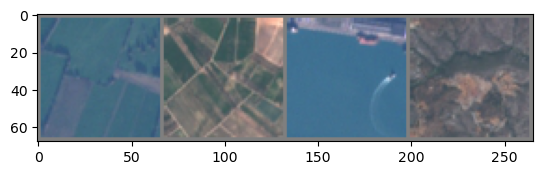

Real label: Pasture PermanentCrop SeaLake HerbaceousVegetation
Predicted:  Pasture Highway Pasture PermanentCrop


In [9]:
images, labels = next(iter(testloader))

outputs = net(images)

_, predicted = torch.max(outputs, 1)


imshow(torchvision.utils.make_grid(images[:4]))
print('Real label:', ' '.join('%s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%s' % classes[predicted[j]]for j in range(4)))

Here, we show an example of how the network predicts images and compares them to the real values. Depending on the sample, the predictions can sometimes be a perfect match, and other times, while not perfect, they are really close!

### Network Prediction

Accuracy of the network on test: 71.67%


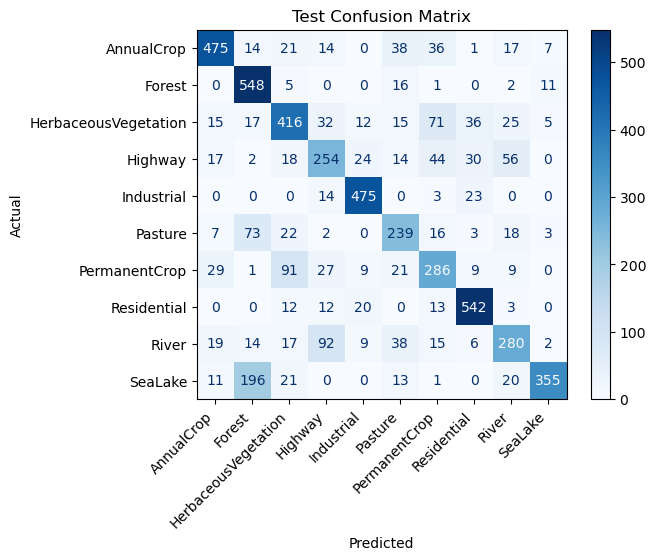

In [10]:
#Let's see how this perform in all the test images

correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy of the network on test: {100 * correct / total:.2f}%")

confusion = confusion_matrix(all_labels, all_predicted)

class_labels = [classes[i] for i in range(len(classes))]

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')


plt.title("Test Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

C:\Users\dlr93\anaconda3\Lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy of the network on training: 76.05%


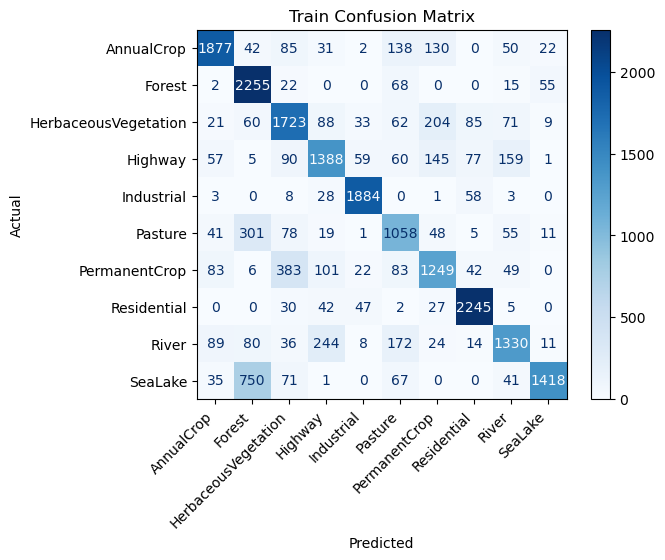

In [11]:
#what about the train data:

correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():
    for data in trainloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Accuracy of the network on training: {100 * correct / total:.2f}%")

confusion = confusion_matrix(all_labels, all_predicted)

class_labels = [classes[i] for i in range(len(classes))]

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')


plt.title("Train Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

**Final takeaways:** Our network seems to be doing a good job classifying the images from the dataset. We have a test accuracy of 72% - 75% (this value changes with each run) and an accuracy of 75% - 79% on the training data. This indicates that we are not overfitting, and the network is not memorizing all the training data. When examining the confusion matrix, it becomes apparent that some categories pose a greater challenge for the network due to the similarity of the images. For example, distinguishing between rivers and highways or between forests and lakes proves to be more difficult.